In [ ]:
# Install the Kaggle package
!pip install kaggle

# Upload kaggle.json (Download it from your Kaggle account > My Account > API section)
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujjawalsah62","key":"3fcb84962264ee7278be2be0c2589974"}'}

In [ ]:
# Set up Kaggle API credentials
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/

# Set permissions for the file
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
# Download the dataset for the competition
!kaggle competitions download -c deepfake-detection-challenge




In [ ]:
# Unzip the dataset
!unzip deepfake-detection-challenge.zip -d /content/dfdc


Archive:  deepfake-detection-challenge.zip
  inflating: /content/dfdc/sample_submission.csv  
  inflating: /content/dfdc/test_videos/aassnaulhq.mp4  
  inflating: /content/dfdc/test_videos/aayfryxljh.mp4  
  inflating: /content/dfdc/test_videos/acazlolrpz.mp4  
  inflating: /content/dfdc/test_videos/adohdulfwb.mp4  
  inflating: /content/dfdc/test_videos/ahjnxtiamx.mp4  
  inflating: /content/dfdc/test_videos/ajiyrjfyzp.mp4  
  inflating: /content/dfdc/test_videos/aktnlyqpah.mp4  
  inflating: /content/dfdc/test_videos/alrtntfxtd.mp4  
  inflating: /content/dfdc/test_videos/aomqqjipcp.mp4  
  inflating: /content/dfdc/test_videos/apedduehoy.mp4  
  inflating: /content/dfdc/test_videos/apvzjkvnwn.mp4  
  inflating: /content/dfdc/test_videos/aqrsylrzgi.mp4  
  inflating: /content/dfdc/test_videos/axfhbpkdlc.mp4  
  inflating: /content/dfdc/test_videos/ayipraspbn.mp4  
  inflating: /content/dfdc/test_videos/bcbqxhziqz.mp4  
  inflating: /content/dfdc/test_videos/bcvheslzrq.mp4  
  inflatin

In [ ]:
import json
import os

metadata_path = "/content/dfdc/train_sample_videos/metadata.json"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

# Show first 5 entries
print("Metadata example:")
for k, v in list(metadata.items())[:5]:
    print(f"{k}: {v}")


Metadata example:
aagfhgtpmv.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'vudstovrck.mp4'}
aapnvogymq.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'jdubbvfswz.mp4'}
abarnvbtwb.mp4: {'label': 'REAL', 'split': 'train', 'original': None}
abofeumbvv.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'atvmxvwyns.mp4'}
abqwwspghj.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'qzimuostzz.mp4'}


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

print("All modules imported successfully!")


All modules imported successfully!


In [ ]:
DATA_FOLDER = '/content/dfdc'
TRAIN_SAMPLE_FOLDER = '/content/dfdc/train_sample_videos'
TEST_FOLDER = '/content/dfdc/test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")


In [ ]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

In [ ]:
for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [ ]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv2.VideoCapture(video_path)
        ret, frame = capture_image.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_FOLDER, subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

play_video(fake_videos[10])

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
import pandas as pd

# Load metadata
metadata = pd.read_json("/content/dfdc/train_sample_videos/metadata.json").T
print(metadata["label"].value_counts())  # Check class distribution


label
FAKE    323
REAL     77
Name: count, dtype: int64


In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00


In [ ]:
!pip install lz4

In [ ]:

import os
import json
import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
from tensorflow.keras.applications import EfficientNetB0, Xception
from tensorflow.keras.layers import Dense, LSTM, Flatten, Concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from mtcnn import MTCNN
import transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_dir = "/content/drive/MyDrive/deepfake_processed_faces"


In [ ]:
from mtcnn import MTCNN
import cv2
import os
import json
from tqdm import tqdm  # Progress bar

# Initialize MTCNN detector
detector = MTCNN()

def extract_faces(video_path, label, save_dir="/content/drive/MyDrive/deepfake_processed_faces", frame_skip=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % frame_skip != 0:
            continue  # Skip frames to reduce processing time

        face_data = detector.detect_faces(frame)
        if face_data:
            x, y, w, h = face_data[0]['box']
            x, y = max(0, x), max(0, y)  # prevent negative indices
            face = frame[y:y+h, x:x+w]
            try:
                face = cv2.resize(face, (224, 224))  # Resize for model input
                frames.append(face)
            except:
                continue  # skip broken crops

    cap.release()

    # Save extracted faces
    if frames:
        save_path = os.path.join(save_dir, label)
        os.makedirs(save_path, exist_ok=True)
        for i, face in enumerate(frames[:5]):  # Save up to 5 faces per video
            filename = f"{os.path.splitext(os.path.basename(video_path))[0]}_{i}.jpg"
            cv2.imwrite(os.path.join(save_path, filename), face)

# Load metadata
metadata_path = "/content/dfdc/train_sample_videos/metadata.json"
video_dir = "/content/dfdc/train_sample_videos"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

# Process dataset with progress bar
print("🔄 Extracting faces from videos (every 10th frame)...")
for video, info in tqdm(metadata.items(), total=len(metadata), desc="Processing Videos"):
    video_path = os.path.join(video_dir, video)
    extract_faces(video_path, label=info["label"])

print("✅ Face extraction complete!")


🔄 Extracting faces from videos (every 10th frame)...


Processing Videos: 100%|██████████| 400/400 [7:34:58<00:00, 68.25s/it]

✅ Face extraction complete!


In [ ]:
import os

# Path where faces are saved
face_dir = "/content/drive/MyDrive/deepfake_processed_faces"

total_faces = 0
class_counts = {}

for label in os.listdir(face_dir):
    label_path = os.path.join(face_dir, label)
    if os.path.isdir(label_path):
        count = len([f for f in os.listdir(label_path) if f.endswith(".jpg")])
        class_counts[label] = count
        total_faces += count

# Print summary
print("📊 Extracted Face Counts:")
for label, count in class_counts.items():
    print(f"  {label}: {count} faces")

print(f"\n🔢 Total Faces Extracted: {total_faces}")


📊 Extracted Face Counts:
  FAKE: 1544 faces
  REAL: 1520 faces

🔢 Total Faces Extracted: 3064


In [ ]:



# ---------------------------- 2️⃣ Data Augmentation for REAL Videos ---------------------------- #

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

def augment_images(image_path, save_dir, num_augmented=3):
    image = cv2.imread(image_path)
    for i in range(num_augmented):
        augmented = augment(image=image)['image']
        save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(image_path)}")
        cv2.imwrite(save_path, augmented)

# Augment REAL class
real_images_path = "/content/drive/MyDrive/deepfake_processed_faces/REAL/"
for img_file in os.listdir(real_images_path):
    img_path = os.path.join(real_images_path, img_file)
    augment_images(img_path, real_images_path)

print("✅ Data augmentation complete!")



/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


✅ Data augmentation complete!


In [ ]:
import os

# Path where faces are saved
face_dir = "/content/drive/MyDrive/deepfake_processed_faces"

total_faces = 0
class_counts = {}

for label in os.listdir(face_dir):
    label_path = os.path.join(face_dir, label)
    if os.path.isdir(label_path):
        count = len([f for f in os.listdir(label_path) if f.endswith(".jpg")])
        class_counts[label] = count
        total_faces += count

# Print summary
print("📊 Extracted Face Counts:")
for label, count in class_counts.items():
    print(f"  {label}: {count} faces")

print(f"\n🔢 Total Faces Extracted: {total_faces}")


📊 Extracted Face Counts:
  FAKE: 1544 faces
  REAL: 1520 faces

🔢 Total Faces Extracted: 3064


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, LSTM, Dense, Lambda
from tensorflow.keras.applications import EfficientNetB0, Xception
from tensorflow.keras.models import Model
from transformers import TFAutoModel
import numpy as np

# Custom ViT Layer with proper Keras integration
class ViTLayer(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        self.model_name = model_name
        self.normalize = tf.keras.layers.Normalization(
            mean=[0.5, 0.5, 0.5], variance=[0.5, 0.5, 0.5]
        )

    def build(self, input_shape):
        # Initialize normalization
        self.normalize.build(input_shape=input_shape)
        # Initialize ViT model in build() to ensure proper tensor handling
        self.vit = TFAutoModel.from_pretrained(self.model_name)
        super().build(input_shape)

    def call(self, inputs):
        # Normalize inputs
        x = self.normalize(inputs)
        # Convert channels-last to channels-first
        x = tf.transpose(x, perm=[0, 3, 1, 2])
        # Get ViT features
        vit_features = self.vit(x).last_hidden_state
        # Average across patches
        return tf.reduce_mean(vit_features, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.vit.config.hidden_size)

# Hybrid Model Builder
def build_hybrid_model():
    # CNN Feature Extractors
    efficientnet = EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )
    xception = Xception(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )
    efficientnet.trainable = False
    xception.trainable = False

    # Input
    input_layer = Input(shape=(224, 224, 3), name="input_image")

    # Feature Extraction
    effnet_features = GlobalAveragePooling2D()(efficientnet(input_layer))
    xception_features = GlobalAveragePooling2D()(xception(input_layer))
    vit_features = ViTLayer()(input_layer)

    # Feature Fusion
    merged = Concatenate()([effnet_features, xception_features, vit_features])

    # Classifier
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(merged)  # Add sequence dim
    x = LSTM(128)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    output = Dense(1, activation="sigmoid")(x)

    # Compile
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Build and test
print("Building model...")
model = build_hybrid_model()
model.summary()



Building model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['vit.encoder.layer.2.output.dense.bias', 'vit.encoder.layer.3.attention.attention.key.weight', 'vit.encoder.layer.9.attention.attention.query.bias', 'vit.encoder.layer.5.attention.output.dense.bias', 'vit.encoder.layer.8.attention.output.dense.weight', 'vit.encoder.layer.10.layernorm_after.bias', 'vit.encoder.layer.3.layernorm_after.bias', 'vit.encoder.layer.4.attention.attention.key.bias', 'vit.encoder.layer.3.attention.attention.value.weight', 'vit.encoder.layer.9.attention.attention.value.weight', 'vit.encoder.layer.4.layernorm_after.bias', 'vit.encoder.layer.7.output.dense.bias', 'vit.encoder.layer.11.attention.output.dense.bias', 'vit.encoder.layer.6.attention.attention.key.bias', 'vit.encoder.layer.4.attention.output.dense.weight', 'vit.encoder.layer.8.attention.attention.key.weight', 'vit.encoder.layer.10.attention.attention.key.bias', 'vit.encoder.layer.11.layernorm_before.weight', '

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_image[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ input_image[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_layer          │ (None, 768)       │          0 │ input_image[0][0] │
│ (ViTLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ vi_t_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 4096)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │  2,163,200 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,099,084 (103.37 MB)

 Trainable params: 2,188,033 (8.35 MB)

 Non-trainable params: 24,911,051 (95.03 MB)

In [ ]:
# ---------------------------- 5️⃣ Train Model with Class Weights ---------------------------- #
import numpy as np # Import numpy

# Convert classes to NumPy array
classes = np.array([0, 1])

class_weights = compute_class_weight("balanced", classes=classes, y=y_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

history = model.fit(image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                                 batch_size=32,
                                                 image_size=(224, 224),
                                                 validation_split=0.2,
                                                 subset="training",
                                                 seed=42),
                    validation_data=image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                                                 batch_size=32,
                                                                 image_size=(224, 224),
                                                                 validation_split=0.2,
                                                                 subset="validation",
                                                                 seed=42),
                    epochs=10,
                    class_weight=class_weights_dict)

print("✅ Model training complete!")



NameError: name 'y_resampled' is not defined

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os

# Load dataset without splitting
full_dataset = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                            batch_size=32,
                                            image_size=(224, 224),
                                            shuffle=True,
                                            seed=42)

# Get class names and labels
class_names = full_dataset.class_names  # ['FAKE', 'REAL']
labels = []

for images, batch_labels in full_dataset:
    labels.extend(batch_labels.numpy())

labels = np.array(labels)

# Compute class weights from actual labels
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("✅ Class weights computed:", class_weights_dict)


Found 3064 files belonging to 2 classes.
✅ Class weights computed: {0: np.float64(0.9922279792746114), 1: np.float64(1.0078947368421052)}


In [ ]:
history = model.fit(
    image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                 batch_size=32,
                                 image_size=(224, 224),
                                 validation_split=0.2,
                                 subset="training",
                                 seed=42),
    validation_data=image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                                 batch_size=32,
                                                 image_size=(224, 224),
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=42),
    epochs=20,
    class_weight=class_weights_dict
)


Found 3064 files belonging to 2 classes.
Using 2452 files for training.
Found 3064 files belonging to 2 classes.
Using 612 files for validation.
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7729 - loss: 0.4803 - val_accuracy: 0.8186 - val_loss: 0.4150
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 72s 915ms/step - accuracy: 0.8335 - loss: 0.3979 - val_accuracy: 0.7925 - val_loss: 0.3999
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 911ms/step - accuracy: 0.8668 - loss: 0.3393 - val_accuracy: 0.8725 - val_loss: 0.3096
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 909ms/step - accuracy: 0.8793 - loss: 0.2923 - val_accuracy: 0.8170 - val_loss: 0.3821
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 915ms/step - accuracy: 0.8814 - loss: 0.2667 - val_accuracy: 0.8856 - val_loss: 0.2564
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 911ms/step - accuracy: 0.9226 - loss: 0.2200 - val_accuracy: 0.8987 - val_loss: 0.2484
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 912ms/step - accuracy: 0.9243 - loss: 0.19

In [ ]:
import os, shutil, random
from pathlib import Path

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    classes = os.listdir(source_dir)
    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = list(Path(cls_path).glob("*"))
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        train_files = images[:n_train]
        val_files = images[n_train:n_train + n_val]
        test_files = images[n_train + n_val:]

        for split_name, split_files in zip(['train', 'val', 'test'],
                                           [train_files, val_files, test_files]):
            split_dir = os.path.join(output_dir, split_name, cls)
            os.makedirs(split_dir, exist_ok=True)
            for file in split_files:
                shutil.copy(file, split_dir)

split_dataset(
    source_dir="/content/drive/MyDrive/deepfake_processed_faces",
    output_dir="/content/drive/MyDrive/deepfake_processed_faces_split"
)


In [ ]:
base_path = "/content/drive/MyDrive/deepfake_processed_faces_split"

train_ds = image_dataset_from_directory(
    os.path.join(base_path, "train"),
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

val_ds = image_dataset_from_directory(
    os.path.join(base_path, "val"),
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(base_path, "test"),
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 2144 files belonging to 2 classes.
Found 612 files belonging to 2 classes.
Found 308 files belonging to 2 classes.


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights_dict
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"🧪 Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 62s 931ms/step - accuracy: 0.7899 - loss: 0.4791 - val_accuracy: 0.7908 - val_loss: 0.4527
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 929ms/step - accuracy: 0.8219 - loss: 0.4095 - val_accuracy: 0.7974 - val_loss: 0.4172
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 77s 849ms/step - accuracy: 0.8607 - loss: 0.3489 - val_accuracy: 0.8415 - val_loss: 0.3797
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 832ms/step - accuracy: 0.8644 - loss: 0.3209 - val_accuracy: 0.8333 - val_loss: 0.3735
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 959ms/step - accuracy: 0.8904 - loss: 0.2690 - val_accuracy: 0.8023 - val_loss: 0.4017
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 65s 966ms/step - accuracy: 0.9015 - loss: 0.2416 - val_accuracy: 0.8595 - val_loss: 0.2996
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/step - accuracy: 0.8962 - loss: 0.2368 - val_accuracy: 0.8676 - val_loss: 0.3016
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 956ms/step - accuracy: 0.9194 - loss: 0.1989 - val_accu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load your training, validation, and test datasets
train_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces_split",
                                        batch_size=32,
                                        image_size=(224, 224),
                                        validation_split=0.2,
                                        subset="training",
                                        seed=42)

val_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces_split",
                                      batch_size=32,
                                      image_size=(224, 224),
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=42)

test_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces_split",
                                       batch_size=32,
                                       image_size=(224, 224),
                                       validation_split=0.2,
                                       subset="testing",
                                       seed=42)

# Function to get predictions and true labels
def get_predictions(dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# Get predictions for training, validation, and test sets
y_train_true, y_train_pred = get_predictions(train_ds)
y_val_true, y_val_pred = get_predictions(val_ds)
y_test_true, y_test_pred = get_predictions(test_ds)

# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-Score": round(f1_score(y_true, y_pred) * 100, 2)
    }

train_metrics = compute_metrics(y_train_true, y_train_pred)
val_metrics = compute_metrics(y_val_true, y_val_pred)
test_metrics = compute_metrics(y_test_true, y_test_pred)

# Create table
df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Training": [train_metrics["Accuracy"], train_metrics["Precision"], train_metrics["Recall"], train_metrics["F1-Score"]],
    "Validation": [val_metrics["Accuracy"], val_metrics["Precision"], val_metrics["Recall"], val_metrics["F1-Score"]],
    "Testing": [test_metrics["Accuracy"], test_metrics["Precision"], test_metrics["Recall"], test_metrics["F1-Score"]]
})

# Print the metrics table
print(df_metrics)

# Optional: Plot table
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_metrics.values,
                 colLabels=df_metrics.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=["lightblue"]*4)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Performance Metrics of Hybrid Deepfake Detection Model", fontsize=14, pad=20)
plt.show()


Found 3064 files belonging to 3 classes.
Using 2452 files for training.
Found 3064 files belonging to 3 classes.
Using 612 files for validation.


ValueError: `subset` must be either "training", "validation" or "both", received: testing

In [ ]:
train_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces_split/train",
                                        batch_size=32,
                                        image_size=(224, 224),
                                        shuffle=True)

val_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces_split/val",
                                      batch_size=32,
                                      image_size=(224, 224),
                                      shuffle=True)

test_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces_split/test",
                                       batch_size=32,
                                       image_size=(224, 224),
                                       shuffle=False)


Found 2144 files belonging to 2 classes.
Found 612 files belonging to 2 classes.
Found 308 files belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

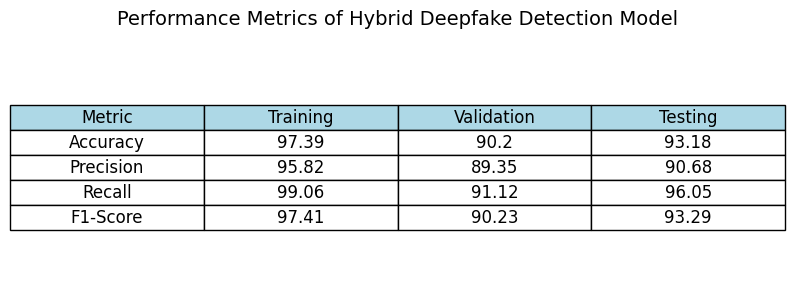

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Make sure test_ds is already loaded like this:
# test_ds = image_dataset_from_directory(...)

# ✅ Function to get predictions and true labels
def get_predictions(dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# ✅ Function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-Score": round(f1_score(y_true, y_pred) * 100, 2)
    }

# ✅ Get predictions for training, validation, and testing sets
y_train_true, y_train_pred = get_predictions(train_ds)
y_val_true, y_val_pred = get_predictions(val_ds)
y_test_true, y_test_pred = get_predictions(test_ds)

# ✅ Compute metrics for each
train_metrics = compute_metrics(y_train_true, y_train_pred)
val_metrics = compute_metrics(y_val_true, y_val_pred)
test_metrics = compute_metrics(y_test_true, y_test_pred)

# ✅ Create metrics DataFrame
df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Training": [train_metrics["Accuracy"], train_metrics["Precision"], train_metrics["Recall"], train_metrics["F1-Score"]],
    "Validation": [val_metrics["Accuracy"], val_metrics["Precision"], val_metrics["Recall"], val_metrics["F1-Score"]],
    "Testing": [test_metrics["Accuracy"], test_metrics["Precision"], test_metrics["Recall"], test_metrics["F1-Score"]]
})

print(df_metrics)

# ✅ Optional: Plot the metrics table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_metrics.values,
                 colLabels=df_metrics.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=["lightblue"]*4)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Performance Metrics of Hybrid Deepfake Detection Model", fontsize=14, pad=20)
plt.show()


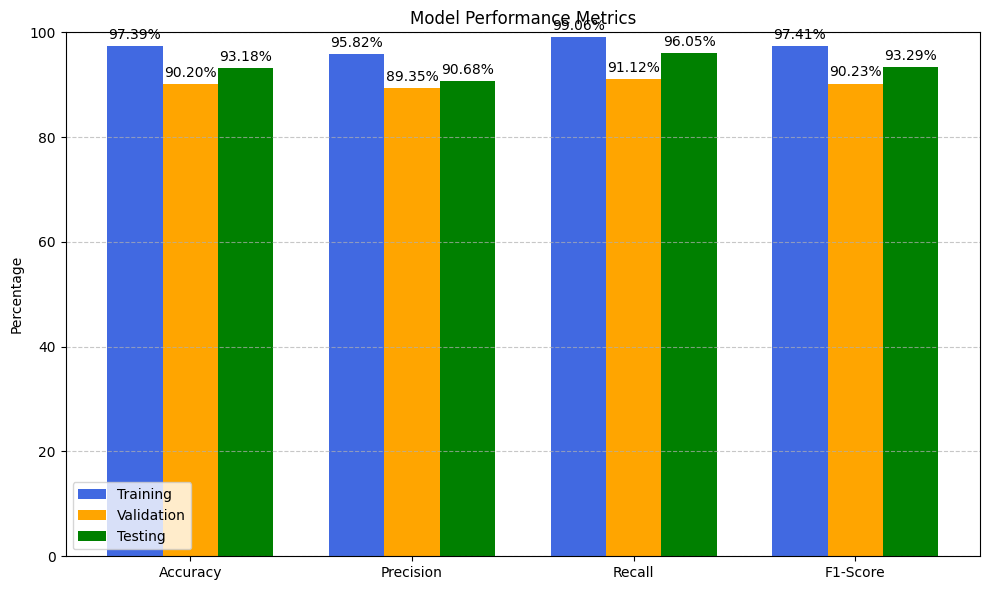

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
training_scores = df_metrics["Training"].values
validation_scores = df_metrics["Validation"].values
testing_scores = df_metrics["Testing"].values

x = np.arange(len(metrics))  # [0, 1, 2, 3]
width = 0.25  # Width of each bar

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, training_scores, width, label='Training', color='royalblue')
bars2 = ax.bar(x, validation_scores, width, label='Validation', color='orange')
bars3 = ax.bar(x + width, testing_scores, width, label='Testing', color='green')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Labels and formatting
ax.set_ylabel('Percentage')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 100)
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Define path where you want to save
save_path = '/content/drive/MyDrive/deepfake_model/ddefendai.h5'

# Save the model
model.save(save_path)

print("✅ Model saved to:", save_path)


✅ Model saved to: /content/drive/MyDrive/deepfake_model/ddefendai.h5


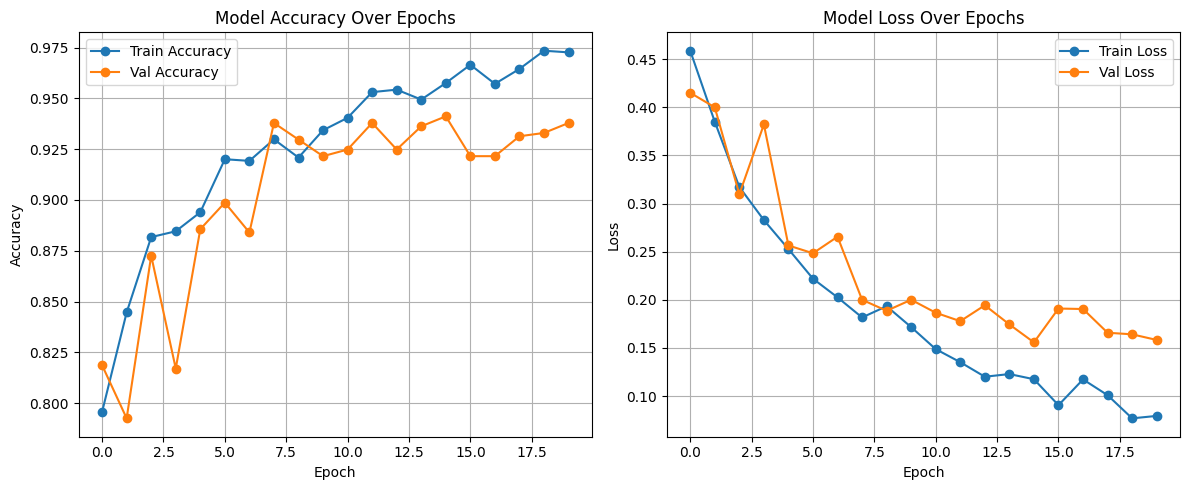

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import os

model_dir = "/content/drive/MyDrive/defeendai_model"
os.makedirs(model_dir, exist_ok=True)


In [ ]:
model.save(os.path.join(model_dir, "defeendai.h5"))


Found 3064 files belonging to 2 classes.
Using 612 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


<Figure size 600x400 with 0 Axes>

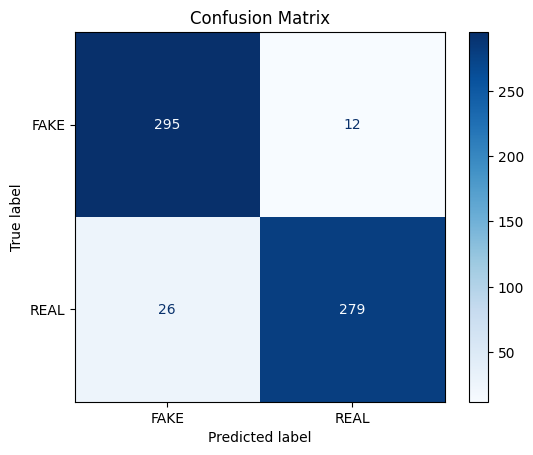

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Step 1: Load your validation dataset (same as used in training)
val_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/deepfake_processed_faces",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

# Step 2: Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Step 3: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])

# Step 4: Plot
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Found 3064 files belonging to 2 classes.
Using 612 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


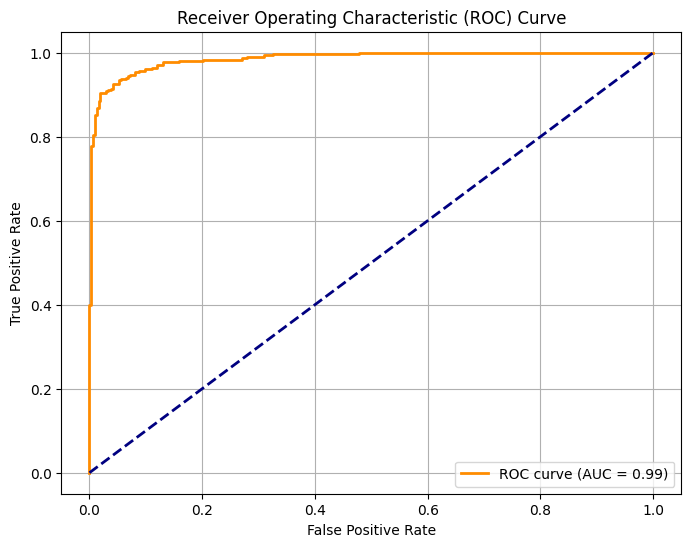

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Step 1: Load validation dataset
val_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/deepfake_processed_faces",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

# Step 2: Get true labels and prediction probabilities
y_true = []
y_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_probs.extend(preds.flatten())       # raw probabilities
    y_true.extend(labels.numpy())         # true labels

# Step 3: Calculate ROC and AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Step 4: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# --------------- 1️⃣ Get predictions for each split --------------- #

# Assuming you already have these datasets
train_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                        batch_size=32,
                                        image_size=(224, 224),
                                        validation_split=0.2,
                                        subset="training",
                                        seed=42)

val_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                      batch_size=32,
                                      image_size=(224, 224),
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=42)

# Load test set
test_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_test_faces",
                                       batch_size=32,
                                       image_size=(224, 224))

# Function to get predictions and labels
def get_predictions(dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# Get results
y_train_true, y_train_pred = get_predictions(train_ds)
y_val_true, y_val_pred = get_predictions(val_ds)
y_test_true, y_test_pred = get_predictions(test_ds)

# --------------- 2️⃣ Compute Metrics --------------- #

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-Score": round(f1_score(y_true, y_pred) * 100, 2)
    }

train_metrics = compute_metrics(y_train_true, y_train_pred)
val_metrics = compute_metrics(y_val_true, y_val_pred)
test_metrics = compute_metrics(y_test_true, y_test_pred)

# --------------- 3️⃣ Create Table --------------- #

df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Training": [train_metrics["Accuracy"], train_metrics["Precision"], train_metrics["Recall"], train_metrics["F1-Score"]],
    "Validation": [val_metrics["Accuracy"], val_metrics["Precision"], val_metrics["Recall"], val_metrics["F1-Score"]],
    "Testing": [test_metrics["Accuracy"], test_metrics["Precision"], test_metrics["Recall"], test_metrics["F1-Score"]]
})

print(df_metrics)

# --------------- 4️⃣ Optional: Visualize Table --------------- #
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_metrics.values,
                 colLabels=df_metrics.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=["lightblue"]*4)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Performance Metrics of Hybrid Deepfake Detection Model", fontsize=14, pad=20)
plt.show()


Found 3064 files belonging to 2 classes.
Using 2452 files for training.
Found 3064 files belonging to 2 classes.
Using 612 files for validation.


NotFoundError: Could not find directory /content/drive/MyDrive/deepfake_test_faces

Found 3064 files belonging to 2 classes.
Using 2452 files for training.
Found 3064 files belonging to 2 classes.
Using 612 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/st

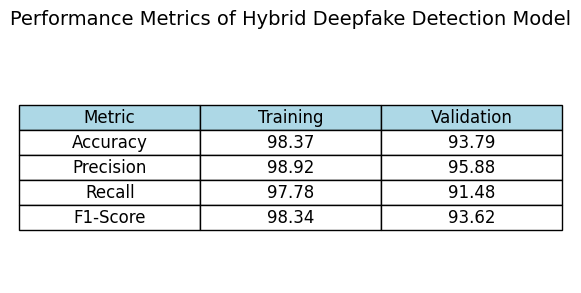

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your training and validation datasets
train_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                        batch_size=32,
                                        image_size=(224, 224),
                                        validation_split=0.2,
                                        subset="training",
                                        seed=42)

val_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                      batch_size=32,
                                      image_size=(224, 224),
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=42)

# Function to get predictions and true labels
def get_predictions(dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# Get predictions
y_train_true, y_train_pred = get_predictions(train_ds)
y_val_true, y_val_pred = get_predictions(val_ds)

# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-Score": round(f1_score(y_true, y_pred) * 100, 2)
    }

train_metrics = compute_metrics(y_train_true, y_train_pred)
val_metrics = compute_metrics(y_val_true, y_val_pred)

# Create table
df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Training": [train_metrics["Accuracy"], train_metrics["Precision"], train_metrics["Recall"], train_metrics["F1-Score"]],
    "Validation": [val_metrics["Accuracy"], val_metrics["Precision"], val_metrics["Recall"], val_metrics["F1-Score"]]
})

print(df_metrics)

# Optional: Plot table
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_metrics.values,
                 colLabels=df_metrics.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=["lightblue"]*3)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Performance Metrics of Hybrid Deepfake Detection Model", fontsize=14, pad=20)
plt.show()


Found 3064 files belonging to 2 classes.
Using 2452 files for training.
Found 3064 files belonging to 2 classes.
Using 612 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/st

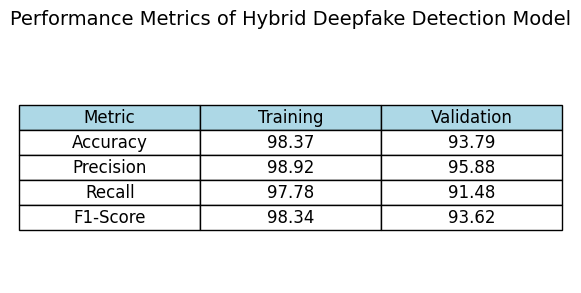

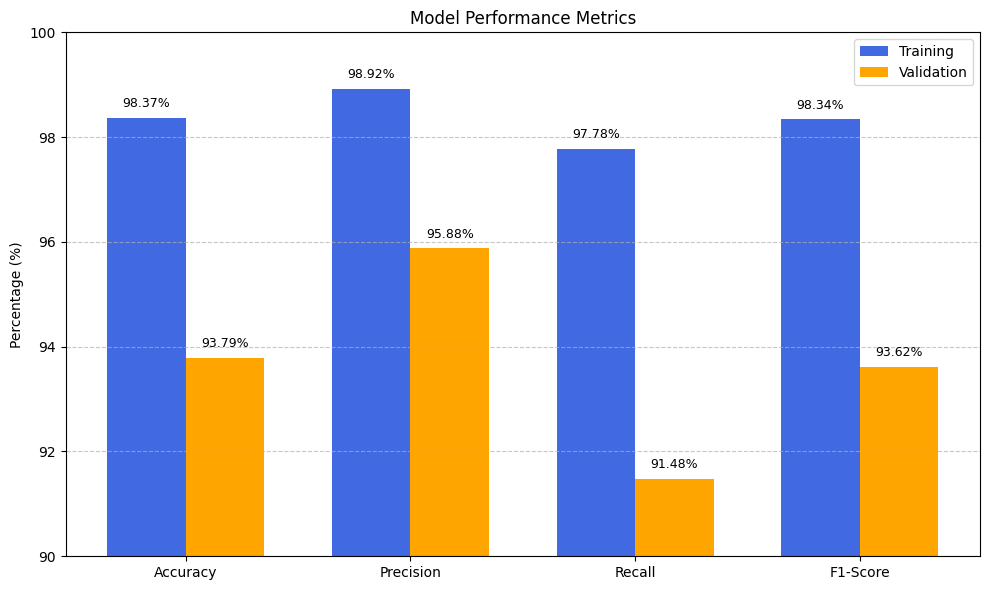

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import image_dataset_from_directory

# Load your training and validation datasets
train_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                        batch_size=32,
                                        image_size=(224, 224),
                                        validation_split=0.2,
                                        subset="training",
                                        seed=42)

val_ds = image_dataset_from_directory("/content/drive/MyDrive/deepfake_processed_faces",
                                      batch_size=32,
                                      image_size=(224, 224),
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=42)

# Function to get predictions and true labels
def get_predictions(dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# Get predictions
y_train_true, y_train_pred = get_predictions(train_ds)
y_val_true, y_val_pred = get_predictions(val_ds)

# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred) * 100, 2),
        "Precision": round(precision_score(y_true, y_pred) * 100, 2),
        "Recall": round(recall_score(y_true, y_pred) * 100, 2),
        "F1-Score": round(f1_score(y_true, y_pred) * 100, 2)
    }

train_metrics = compute_metrics(y_train_true, y_train_pred)
val_metrics = compute_metrics(y_val_true, y_val_pred)

# Create DataFrame
df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Training": [train_metrics["Accuracy"], train_metrics["Precision"], train_metrics["Recall"], train_metrics["F1-Score"]],
    "Validation": [val_metrics["Accuracy"], val_metrics["Precision"], val_metrics["Recall"], val_metrics["F1-Score"]]
})

print(df_metrics)

# Plot table
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_metrics.values,
                 colLabels=df_metrics.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=["lightblue"]*3)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
plt.title("Performance Metrics of Hybrid Deepfake Detection Model", fontsize=14, pad=20)
plt.show()

# --------------------- 📊 Add Bar Chart for Comparison ---------------------
# Prepare data for bar chart
labels = df_metrics["Metric"]
x = np.arange(len(labels))
training_scores = df_metrics["Training"]
validation_scores = df_metrics["Validation"]
width = 0.35

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, training_scores, width, label="Training", color="royalblue")
plt.bar(x + width/2, validation_scores, width, label="Validation", color="orange")

# Add value labels
for i in range(len(x)):
    plt.text(x[i] - width/2, training_scores[i] + 0.2, f"{training_scores[i]}%", ha='center', fontsize=9)
    plt.text(x[i] + width/2, validation_scores[i] + 0.2, f"{validation_scores[i]}%", ha='center', fontsize=9)

plt.xticks(x, labels)
plt.ylabel("Percentage (%)")
plt.ylim(90, 100)
plt.title("Model Performance Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Grad-CAM Visualization
from tensorflow.keras.models import Model
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cm.jet(heatmap)[:, :, :3] * 255
    superimposed_img = heatmap * alpha + img
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()


In [ ]:
import cv2
from mtcnn import MTCNN

# Load face detector
detector = MTCNN()

def extract_faces(video_path, label="test", max_frames=30):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    faces = []

    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(frame)

        for det in detections:
            x, y, w, h = det['box']
            face = frame[y:y+h, x:x+w]
            if face.size != 0:
                faces.append(face)
                break  # Take only one face per frame

        frame_count += 1

    cap.release()
    return faces


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/defendai_model.h5")
print("HDF5 Model loaded successfully!")

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]

# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = "/content/dfdc/test_videos/aayfryxljh.mp4"
print(f"Test video path: {test_video}")

prediction = sequence_prediction(test_video)  # Get the prediction confidence score

confidence = round(float(prediction), 4)  # Convert to float and round to 4 decimal places

if(sequence_prediction(test_video)>0.5):
    print(f'The predicted class of the video is FAKE with confidence {confidence}')
else:
    print(f'The predicted class of the video is REAL with confidence {1 - confidence}')

play_video(test_video,TEST_FOLDER)

# test_videos_list = test_videos["video"].values.tolist()[:10]  # Get the first 10 video filenames

# for test_video in test_videos_list:
#     print(f"\nTest video path: {test_video}")

#     prediction = sequence_prediction(test_video)  # Get the prediction confidence score

#     confidence = round(float(prediction), 4)  # Convert to float and round to 4 decimal places

#     if prediction >= 0.6:
#         print(f'The predicted class of the video is FAKE with confidence {confidence}')
#     else:
#         print(f'The predicted class of the video is REAL with confidence {1-confidence}')

#     play_video(test_video, TEST_FOLDER)  # Play the video (if needed)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

In [ ]:
import os
import tensorflow as tf
import numpy as np

# Function to predict on a single video and return label + confidence
def predict_video(video_path):
    faces = extract_faces(video_path, label="test")
    predictions = []

    for face in faces:
        img = tf.image.resize(face, (224, 224)) / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)[0][0]
        predictions.append(pred)

    avg_prediction = np.mean(predictions)
    label = "FAKE" if avg_prediction > 0.5 else "REAL"
    confidence = round(avg_prediction * 100, 2) if label == "FAKE" else round((1 - avg_prediction) * 100, 2)
    return label, confidence

# Directory path to test videos
test_videos_path = "/content/dfdc/test_videos"

# Get list of first 10 video files
video_files = sorted([f for f in os.listdir(test_videos_path) if f.endswith(".mp4")])[:10]

# Predict and print results for each video
print("Video Name\t\tPrediction\tConfidence")
for video in video_files:
    video_path = os.path.join(test_videos_path, video)
    label, confidence = predict_video(video_path)
    print(f"{video}\t{label}\t\t{confidence}%")


Video Name		Prediction	Confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━

In [ ]:
# Grad-CAM Visualization
from tensorflow.keras.models import Model
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cm.jet(heatmap)[:, :, :3] * 255
    superimposed_img = heatmap * alpha + img
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()
